
# EDA del Dataset **TrashNet** (Clasificación de Residuos)

Este notebook realiza un **Análisis Exploratorio de Datos (EDA)** completo del dataset TrashNet.  
Objetivos principales:

1) **Inventariar** el dataset (rutas, clases, tamaños)  
2) **Diagnosticar balance** por clase y posibles sesgos  
3) **Caracterizar** las imágenes (dimensiones, brillo/contraste, color promedio, nitidez, densidad de bordes)  
4) **Detectar duplicados** y similitudes fuertes  
5) **Explorar estructura** global con una proyección PCA de histogramas RGB  
6) **Exportar metadatos** para trazabilidad / futuros experimentos



## 1) Importación de librerías y configuración
Se fijan semillas para reproducibilidad y se configuran opciones de impresión.


In [ ]:

import os, math, random, hashlib, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import kagglehub

np.random.seed(42); random.seed(42)
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_colwidth", 200)



## 2) Carga del dataset y descubrimiento de estructura de carpetas
Se descarga el dataset desde Kaggle (o se reutilizan variables si ya están definidas) y se infieren las **clases** desde las subcarpetas.


In [ ]:

try:
    dataset_path
    categories
    all_image_paths
except NameError:
    path = kagglehub.dataset_download("feyzazkefe/trashnet")
    subdirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    dataset_path = os.path.join(path, subdirs[0])
    categories = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    all_image_paths = []
    for c in categories:
        cp = os.path.join(dataset_path, c)
        ps = [os.path.join(cp, f) for f in os.listdir(cp) if f.lower().endswith((".jpg",".jpeg",".png"))]
        all_image_paths.extend(ps)

len(dataset_path), len(categories), len(all_image_paths), sorted(categories)[:10]


100%|██████████| 40.8M/40.8M [00:00<00:00, 46.3MB/s]

Extracting files...


(78, 6, 2527, ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'])


## 3) Inventario: tabla de rutas y etiquetas
Se construye un `DataFrame` con **ruta** y **clase** para cada imagen, ordenado aleatoriamente.


In [ ]:

labels = [os.path.basename(os.path.dirname(p)) for p in all_image_paths]
df = pd.DataFrame({"path": all_image_paths, "label": labels}).sample(frac=1, random_state=42).reset_index(drop=True)
df.head(10)


,path,label
0,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/glass/glass228.jpg,glass
1,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/metal/metal167.jpg,metal
2,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/plastic/plastic263.jpg,plastic
3,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/cardboard/cardboard225.jpg,cardboard
4,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/cardboard/cardboard69.jpg,cardboard
5,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/plastic/plastic389.jpg,plastic
6,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/paper/paper368.jpg,paper
7,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/metal/metal312.jpg,metal
8,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/cardboard/cardboard327.jpg,cardboard
9,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/paper/paper532.jpg,paper



## 4) Balance por clase
Se cuantifica el **número de imágenes por clase** y su **porcentaje** relativo para detectar desbalances.


In [ ]:

cnt = df["label"].value_counts().rename_axis("label").reset_index(name="count")
cnt["pct"] = (cnt["count"] / cnt["count"].sum()).round(4)
cnt


,label,count,pct
0,paper,594,0.2351
1,glass,501,0.1983
2,plastic,482,0.1907
3,metal,410,0.1622
4,cardboard,403,0.1595
5,trash,137,0.0542


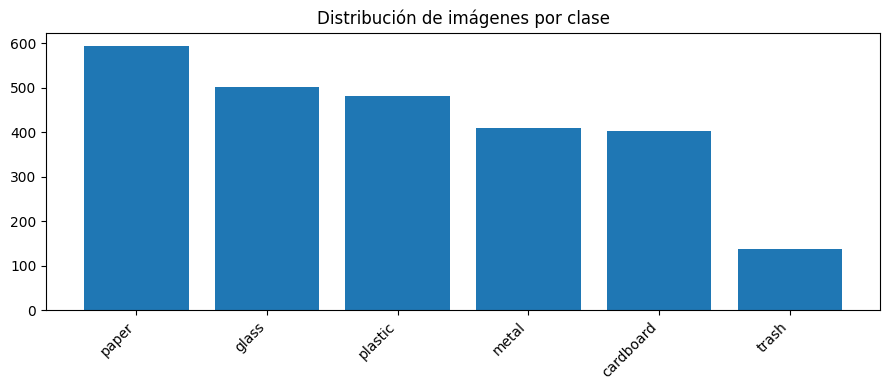

In [ ]:

plt.figure(figsize=(9,4))
x = np.arange(len(cnt))
plt.bar(x, cnt["count"].values)
plt.xticks(x, cnt["label"].values, rotation=45, ha="right")
plt.title("Distribución de imágenes por clase")
plt.tight_layout()
plt.show()



## 5) Muestra visual por clase
Se muestran **n=5** ejemplos por clase para observar variabilidad intra-clase, condiciones de iluminación, fondo, escala, etc.


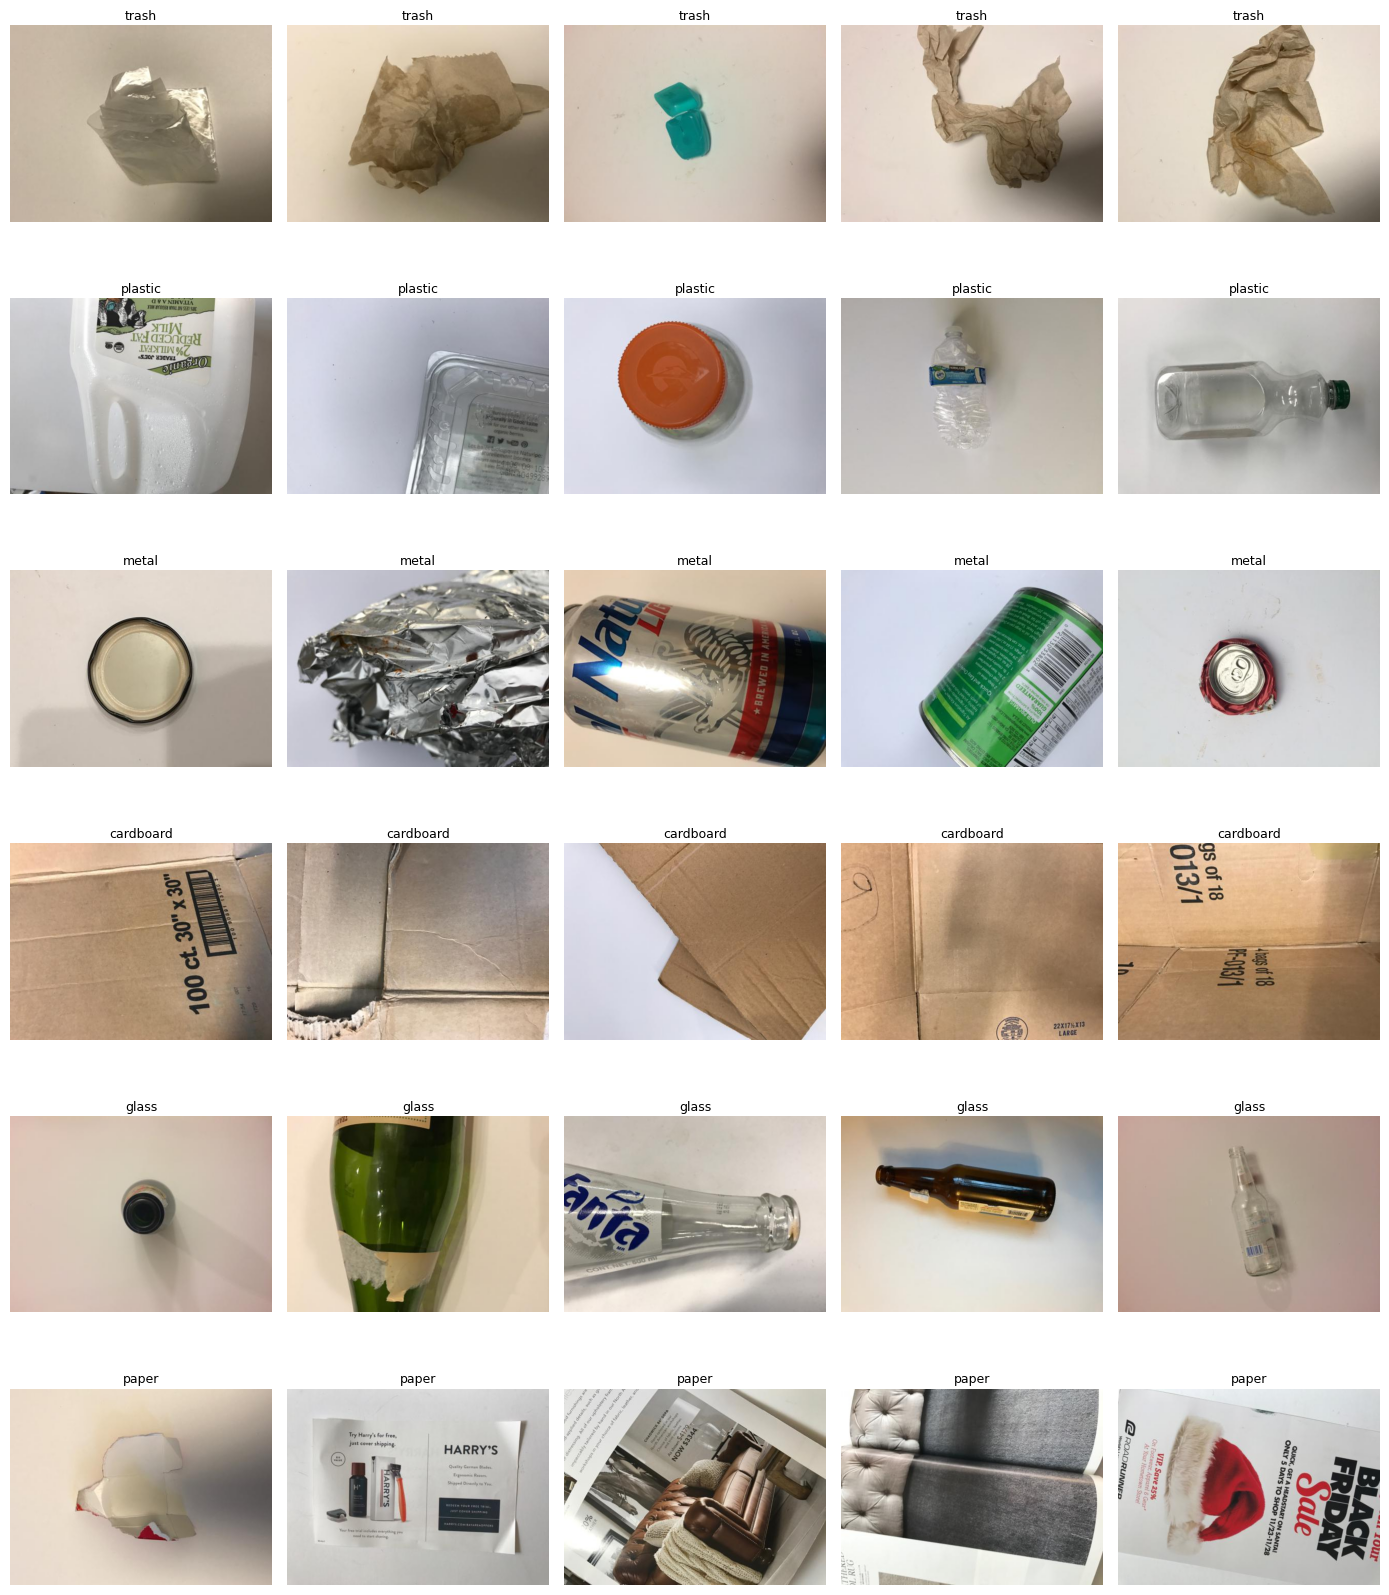

In [ ]:
n = 5
r = len(categories)
c = n

fig, axes = plt.subplots(r, c, figsize=(c*2.8, r*2.8))

for i, cl in enumerate(categories):
    sample = df[df.label == cl].head(n)
    for j, (_, row) in enumerate(sample.iterrows()):
        im = Image.open(row["path"])
        axes[i, j].imshow(im)
        axes[i, j].axis("off")
        axes[i, j].set_title(cl, fontsize=9, pad=4)

plt.tight_layout()
plt.show()


| Columna | Clase / Subcategoría | Descripción visual                                                                                     |
| ------- | -------------------- | ------------------------------------------------------------------------------------------------------ |
| 1       | **Metal**            | Latas de aluminio o envases metálicos (por ej. Monster, latas plateadas, a veces arrugadas o enteras). |
| 2       | **Glass**            | Botellas o frascos de vidrio, transparentes o de color (verde, marrón, transparente).                  |
| 3       | **Paper**            | Hojas impresas, papeles arrugados o con texto/imágenes.                                                |
| 4       | **Trash**            | Residuos varios no reciclables, generalmente papel o material sucio o deformado.                       |
| 5       | **Cardboard**        | Cartón corrugado, cajas marrones o beige, con textura visible.                                         |
| 6       | **Plastic**          | Botellas y envases plásticos (transparente, con etiquetas de colores).                                 |


### Desbalance de clases

El dataset TrashNet presenta un desbalance en la cantidad de imágenes por categoría.  
Este fenómeno se debe principalmente a diferencias en la facilidad de recolección y variabilidad de los objetos:

- **Trash (residuos genéricos)** tiene menos ejemplos porque es una categoría más difusa y difícil de definir visualmente.  
- **Paper** y **Plastic** tienen muchas más imágenes ya que son materiales comunes y fáciles de fotografiar.  
- **Metal** y **Cardboard** presentan menor frecuencia en el entorno de recolección.

El desbalance afecta el entrenamiento de modelos de clasificación, ya que puede generar sesgo hacia las clases mayoritarias.  
Para mitigarlo se deberian aplicar técnicas de data augmentation, class weighting o samplers balanceados durante el entrenamiento

Otro problema que notamos es la similitud entre algunas imagenes de las distintas categorías

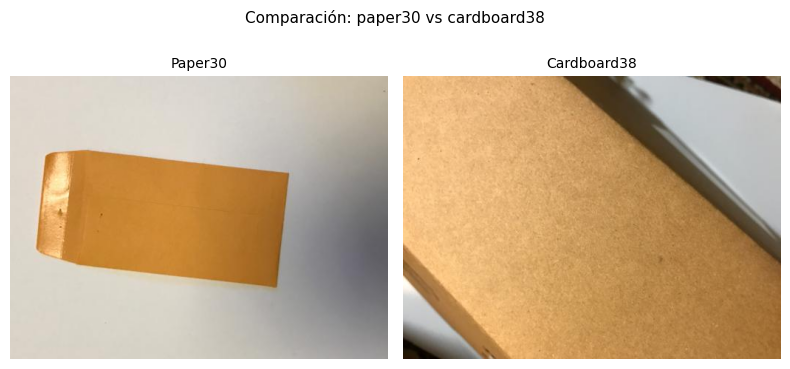

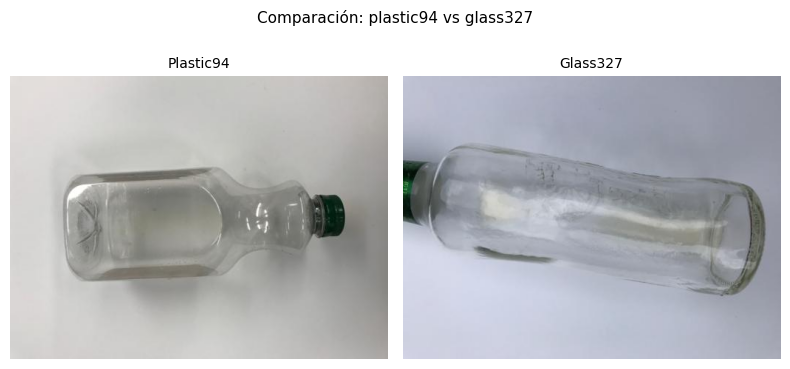

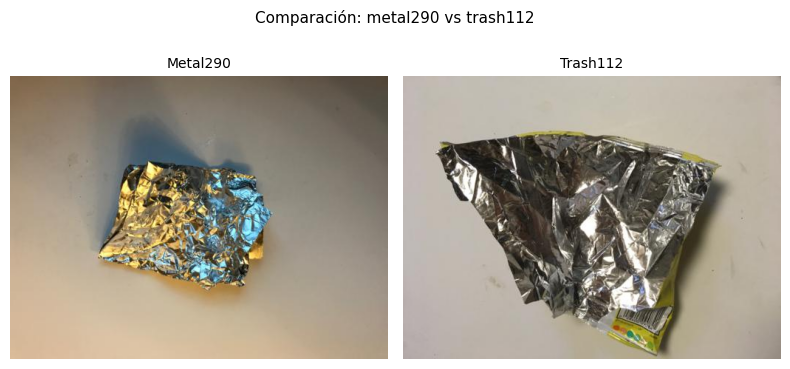

In [ ]:
import matplotlib.image as mpimg

# PARES DE IMÁGENES A COMPARAR ENTRE CLASES SIMILARES
image_pairs = [
    ("paper30.jpg", "cardboard38.jpg"),
    ("plastic94.jpg", "glass327.jpg"),
    ("metal290.jpg", "trash112.jpg")
]

all_image_paths = {}
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            all_image_paths[file] = os.path.join(root, file)

for img1_name, img2_name in image_pairs:
    if img1_name not in all_image_paths or img2_name not in all_image_paths:
        print(f"⚠️  No se encontró alguno de los archivos: {img1_name}, {img2_name}")
        continue

    img1 = mpimg.imread(all_image_paths[img1_name])
    img2 = mpimg.imread(all_image_paths[img2_name])

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(img1)
    axes[0].set_title(img1_name.split('.')[0].capitalize(), fontsize=10)
    axes[0].axis("off")

    axes[1].imshow(img2)
    axes[1].set_title(img2_name.split('.')[0].capitalize(), fontsize=10)
    axes[1].axis("off")

    plt.suptitle(f"Comparación: {img1_name.split('.')[0]} vs {img2_name.split('.')[0]}", fontsize=11)
    plt.tight_layout()
    plt.show()



## 6) Extracción de metadatos por imagen
Para cada imagen se calculan:

- **Dimensiones**: `width`, `height`, `aspect`  
- **Tamaño de archivo**: `filesize` (bytes)  
- **Color promedio**: `r_mean`, `g_mean`, `b_mean`  
- **Brillo/Contraste** en escala de grises: `gray_mean`, `gray_std`  
- **Nitidez aproximada**: varianza del gradiente (`blur_var`)  
- **Complejidad de bordes**: porcentaje de píxeles por encima del percentil 90 del gradiente (`edge_density`)  
- **Hash perceptual simple**: MD5 de una versión 16×16 en gris (sirve para detectar duplicados exactos o casi exactos)  
- **Histogramas RGB**: 16 bins por canal → 48 features en total


In [ ]:

def feats(p):
    st = os.stat(p)
    im = Image.open(p).convert("RGB")
    w,h = im.size
    fs = st.st_size
    arr = np.array(im)
    r,g,b = arr[:,:,0].astype(np.float32), arr[:,:,1].astype(np.float32), arr[:,:,2].astype(np.float32)
    gray = (0.299*r + 0.587*g + 0.114*b).astype(np.float32)
    gx = np.zeros_like(gray); gy = np.zeros_like(gray)
    gx[:,1:-1] = gray[:,2:] - gray[:,:-2]
    gy[1:-1,:] = gray[2:,:] - gray[:-2,:]
    grad = np.hypot(gx, gy)
    thr = np.percentile(grad, 90)

    r_mean, g_mean, b_mean = float(r.mean()), float(g.mean()), float(b.mean())
    gray_mean, gray_std = float(gray.mean()), float(gray.std())
    blur_var = float(grad.var())
    edge_density = float((grad>=thr).mean())

    im_small = im.convert("L").resize((16,16), Image.BILINEAR)
    hsh = hashlib.md5(np.array(im_small).tobytes()).hexdigest()

    hist = []
    for ch in (r,g,b):
        h,_ = np.histogram(ch, bins=16, range=(0,255), density=True)
        hist.extend(h.tolist())

    return [w,h,(w/(h+1e-6)),fs,r_mean,g_mean,b_mean,gray_mean,gray_std,blur_var,edge_density,hsh]+hist

cols = ["width","height","aspect","filesize","r_mean","g_mean","b_mean","gray_mean","gray_std","blur_var","edge_density","hash"]+[f"hist_{i}" for i in range(48)]
M = [feats(p) for p in df["path"]]
meta_df = pd.concat([df, pd.DataFrame(M, columns=cols)], axis=1)
meta_df.head(10)


,path,label,width,height,aspect,filesize,r_mean,g_mean,b_mean,gray_mean,...,hist_38,hist_39,hist_40,hist_41,hist_42,hist_43,hist_44,hist_45,hist_46,hist_47
0,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/glass/glass228.jpg,glass,512,"[1.3403799019607843e-05, 0.0010221992442810458, 0.0004359426062091503, 9.957107843137256e-05, 0.00010850694444444444, 0.0005131740196078432, 0.0007151884191176471, 0.0009679457720588236, 0.0013518...","[35546177.73429191, 500391.299995299, 1171778.610564066, 5090926.815002559, 4675502.568330268, 995771.8213582606, 714895.6703751092, 528409.3442217085, 378455.0080122035, 86565.03149852678, 29422....",6640,198.837662,182.248657,168.419785,185.632309,...,0.000715,0.000968,0.001352,0.005914,0.017401,0.034202,0.000001,0.000000,0.000000e+00,0.000000
1,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/metal/metal167.jpg,metal,512,"[0.00043562346813725487, 0.00034594566993464054, 0.00031498927696078433, 0.0003497753267973856, 0.0004866855596405229, 0.000475515727124183, 0.0005690231821895425, 0.0014045266544117647, 0.0110316...","[1172635.0903315395, 1475735.3798260496, 1620308.1475563534, 1459623.7559654266, 1049856.7978461357, 1074466.1106779578, 898209.0834154024, 364276.26498074504, 46407.72598649246, 86949.74133795002...",10251,196.854813,186.320923,173.508545,188.009949,...,0.000569,0.001405,0.011032,0.005887,0.004175,0.008849,0.025630,0.002787,3.510519e-06,0.000000
2,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/plastic/plastic263.jpg,plastic,512,"[3.925398284313726e-05, 0.00036988102532679737, 0.000690295649509804, 0.0004059436274509804, 0.0027627782883986925, 0.0034744561887254904, 0.0015899458741830067, 0.001756216809640523, 0.0036605136...","[12719238.292398907, 1380496.6149154094, 740638.2498762403, 1258159.5225045623, 185253.64431336062, 147318.78987885016, 321821.1306295544, 291369.8510001966, 139832.87899421487, 136408.7303476764,...",17619,173.742798,173.023575,168.711182,172.747025,...,0.001590,0.001756,0.003661,0.003752,0.005970,0.014183,0.015715,0.006235,1.688240e-03,0.000452
3,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/cardboard/cardboard225.jpg,cardboard,512,"[0.00020584405637254902, 0.0013952716503267974, 0.0011399611928104576, 0.0007455065359477124, 0.0014808006535947712, 0.003004365808823529, 0.015758718852124185, 0.02243221507352941, 0.008447584763...","[2475294.7170878886, 366690.82257751666, 448744.44742403796, 685861.376082931, 345525.5595669463, 170361.95676972377, 32487.889206918793, 22823.300107533236, 60601.86579862607, 249306.6064532144, ...",22185,169.142227,142.304016,116.730461,147.413254,...,0.015759,0.022432,0.008448,0.002053,0.004196,0.001242,0.000556,0.000088,0.000000e+00,0.000000
4,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/cardboard/cardboard69.jpg,cardboard,512,"[8.61672794117647e-06, 0.00012957005718954248, 0.0006925296160130719, 0.0011323018790849674, 0.0011150684232026143, 0.001827065461601307, 0.006340316074346405, 0.00918383629493464, 0.0140609043096...","[53240561.98031157, 3921266.5676997704, 738252.5391537852, 451777.2443943982, 458753.2353355096, 280077.497635949, 80740.3374941804, 55744.05286704606, 36410.431242160026, 48850.97169167618, 65131...",22891,170.049820,154.899658,140.055237,157.737289,...,0.006340,0.009184,0.014061,0.010480,0.007860,0.006597,0.002332,0.000678,2.444598e-04,0.000064
5,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/plastic/plastic389.jpg,plastic,512,"[0.0, 1.5956903594771242e-06, 2.8084150326797384e-05, 0.00015318627450980392, 0.0004276450163398693, 0.0009213516135620916, 0.003043938929738562, 0.0047347324346405225, 0.005057700163398693, 0.002...","[512000000.0, 197250029.50780973, 17604090.00252816, 3320658.739746932, 1194461.571889685, 555102.8398190499, 168147.87153841546, 108114.21613579075, 101211.7705066774, 172542.2946823185,


## 7) Resumen estadístico de metadatos
Tabla descriptiva de las variables numéricas.


In [ ]:

meta_df.describe()


,width,filesize,r_mean,g_mean,b_mean,gray_mean,gray_std,blur_var,edge_density,hist_0,...,hist_38,hist_39,hist_40,hist_41,hist_42,hist_43,hist_44,hist_45,hist_46,hist_47
count,2527.0,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,...,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2.527000e+03
mean,512.0,17127.978631,171.634624,163.148632,154.230018,164.669223,46.357304,315.639999,0.100196,0.000498,...,0.003194,0.003661,0.004589,0.005585,0.006411,0.007592,0.008074,0.005978,0.004620,1.394960e-03
std,0.0,7598.745148,19.500281,20.961226,27.537140,19.995146,15.501777,333.500450,0.001164,0.001419,...,0.003410,0.003780,0.004785,0.005283,0.005467,0.006551,0.007324,0.006427,0.006775,4.034325e-03
min,512.0,5604.000000,78.697136,65.638855,53.687618,77.949959,7.521507,1.209941,0.100001,0.000000,...,0.000000,0.000000,0.000018,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,512.0,11907.500000,163.151642,150.815125,135.210266,153.613503,34.904404,94.844913,0.100001,0.000000,...,0.000931,0.001176,0.001567,0.001914,0.002278,0.002525,0.002257,0.000296,0.000036,6.382761e-07
50%,512.0,15385.000000,173.513168,167.571976,158.761429,168.395813,45.030575,197.542953,0.100001,0.000008,...,0.002156,0.002604,0.003275,0.004268,0.005352,0.006574,0.006680,0.004470,0.000698,5.616830e-05
75%,512.0,20303.000000,183.672409,177.106995,176.336555,177.692665,57.464539,411.668030,0.100016,0.000258,...,0.004164,0.004707,0.006075,0.007662,0.009111,0.010664,0.011338,0.009385,0.007201,6.737005e-04
max,512.0,57868.000000,227.692139,223.231979,222.216354,224.449814,98.734764,2809.757812,0.120646,0.022882,...,0.035967,0.052806,0.057111,0.048649,0.042668,0.046585,0.043461,0.046615,0.046514,3.772340e-02



## 8) Distribución de dimensiones y tamaño de archivo
Se inspeccionan histogramas de **ancho**, **alto**, **aspect ratio** y **tamaño en KB** para detectar tamaños atípicos o necesidad de resize.


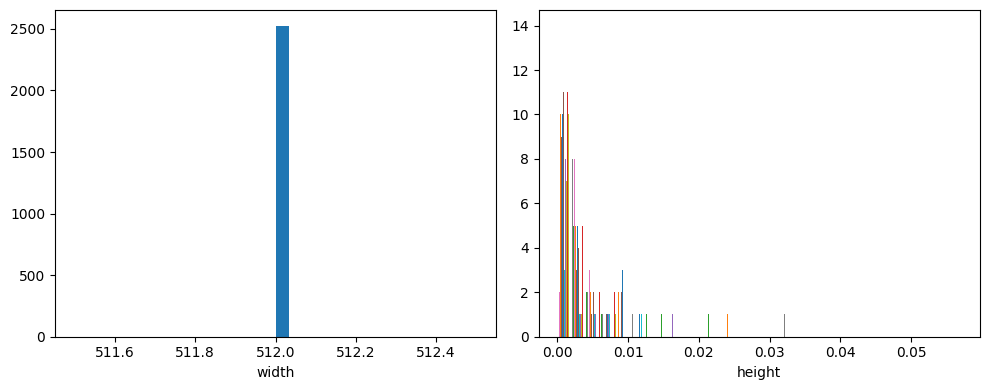

In [ ]:

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(meta_df["width"].dropna(), bins=30)
plt.xlabel("width")
plt.subplot(1,2,2)
plt.hist(meta_df["height"].dropna(), bins=30)
plt.xlabel("height")
plt.tight_layout()
plt.show()


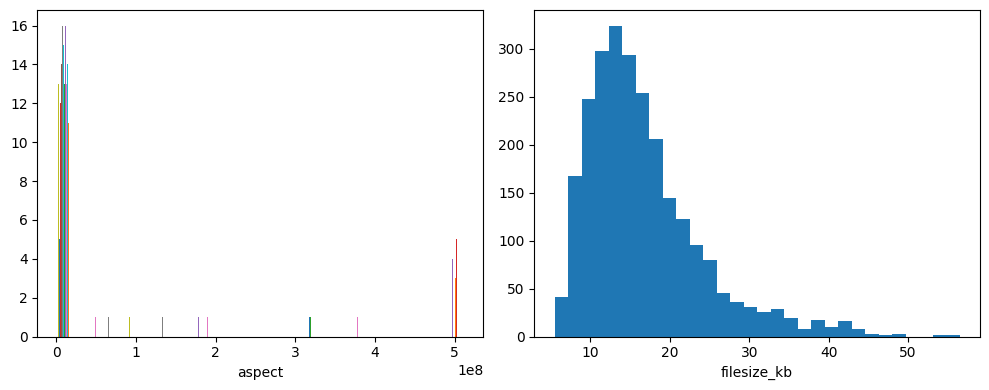

In [ ]:

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(meta_df["aspect"].dropna(), bins=30)
plt.xlabel("aspect")
plt.subplot(1,2,2)
plt.hist((meta_df["filesize"].dropna()/1024.0), bins=30)
plt.xlabel("filesize_kb")
plt.tight_layout()
plt.show()



## 9) Estadísticas por clase: brillo, contraste, nitidez y bordes
Se comparan distribuciones por clase para observar diferencias sistemáticas que puedan afectar el entrenamiento.


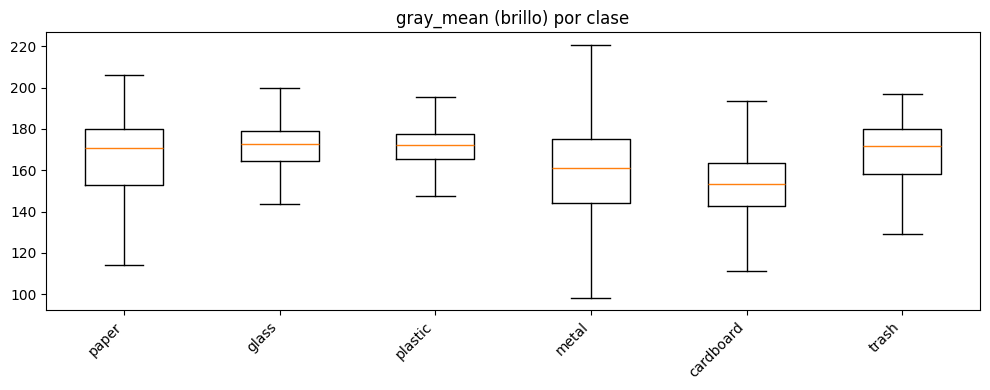

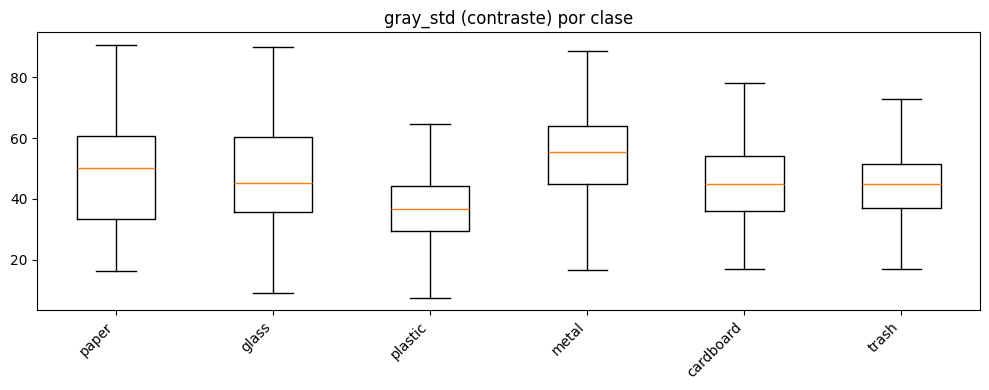

In [ ]:

order = cnt["label"].tolist()
m1 = [meta_df[meta_df.label==cl]["gray_mean"].dropna().values for cl in order]
m2 = [meta_df[meta_df.label==cl]["gray_std"].dropna().values for cl in order]
plt.figure(figsize=(10,4))
plt.boxplot(m1, labels=order, showfliers=False)
plt.xticks(rotation=45, ha="right")
plt.title("gray_mean (brillo) por clase")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.boxplot(m2, labels=order, showfliers=False)
plt.xticks(rotation=45, ha="right")
plt.title("gray_std (contraste) por clase")
plt.tight_layout()
plt.show()


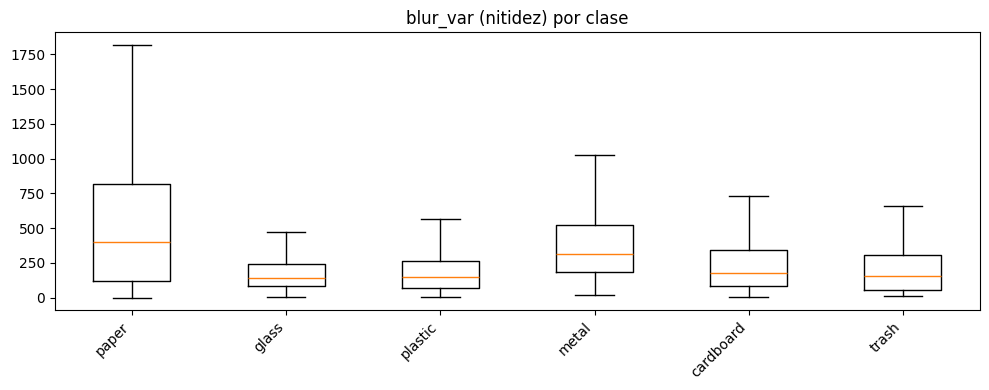

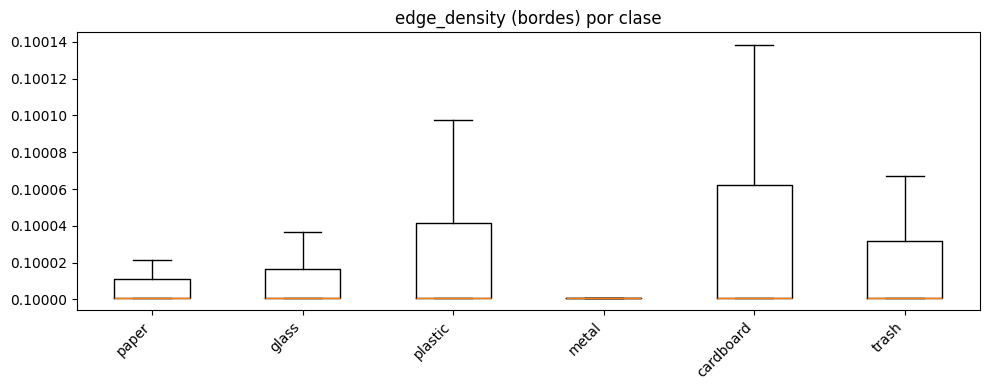

In [ ]:

m3 = [meta_df[meta_df.label==cl]["blur_var"].dropna().values for cl in order]
m4 = [meta_df[meta_df.label==cl]["edge_density"].dropna().values for cl in order]
plt.figure(figsize=(10,4))
plt.boxplot(m3, labels=order, showfliers=False)
plt.xticks(rotation=45, ha="right")
plt.title("blur_var (nitidez) por clase")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.boxplot(m4, labels=order, showfliers=False)
plt.xticks(rotation=45, ha="right")
plt.title("edge_density (bordes) por clase")
plt.tight_layout()
plt.show()



## 10) Color promedio por clase
Se calculan promedios **R/G/B** por clase para visualizar diferencias cromáticas entre categorías.


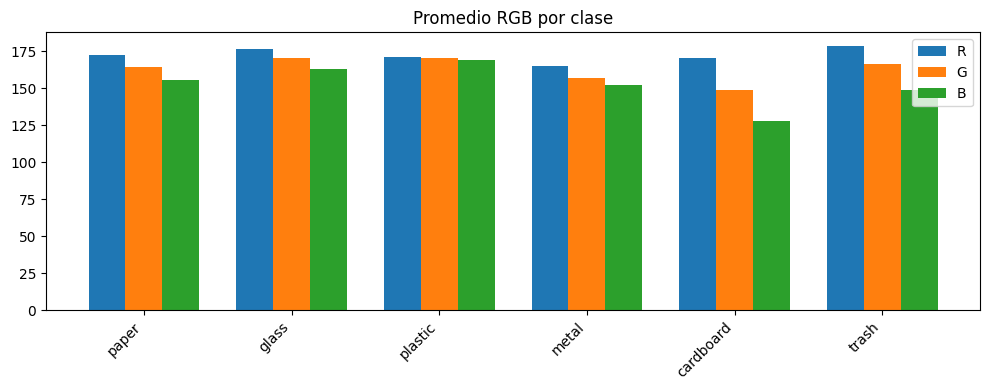

In [ ]:

C = meta_df.groupby("label")[["r_mean","g_mean","b_mean"]].mean().reindex(order)
x = np.arange(len(order)); w = 0.25
plt.figure(figsize=(10,4))
plt.bar(x-w, C["r_mean"].values, width=w, label="R")
plt.bar(x,   C["g_mean"].values, width=w, label="G")
plt.bar(x+w, C["b_mean"].values, width=w, label="B")
plt.xticks(x, order, rotation=45, ha="right")
plt.legend()
plt.title("Promedio RGB por clase")
plt.tight_layout()
plt.show()



## 11) Correlaciones entre metadatos
Matriz de correlación para detectar redundancias o relaciones (p. ej., entre dimensiones y tamaño de archivo).


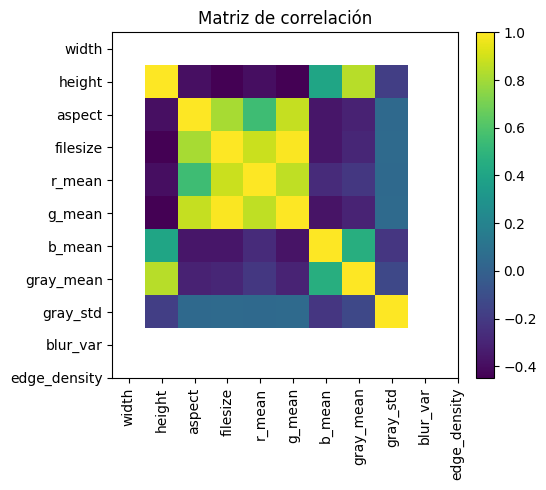

In [ ]:

corr_cols = ["width","height","aspect","filesize","r_mean","g_mean","b_mean","gray_mean","gray_std","blur_var","edge_density"]
C = meta_df[corr_cols].corr(numeric_only=True).values
plt.figure(figsize=(6,5))
plt.imshow(C, interpolation="nearest")
plt.xticks(range(len(corr_cols)), corr_cols, rotation=90)
plt.yticks(range(len(corr_cols)), corr_cols)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("Matriz de correlación")
plt.tight_layout()
plt.show()



## 12) Detección de duplicados
Se marcan imágenes con **hash** repetido como posibles duplicados exactos/casi exactos.


In [ ]:

dup = meta_df.groupby("hash").size().reset_index(name="n")
dup = dup[dup["n"]>1]
dups = meta_df.merge(dup[["hash"]], on="hash", how="inner").sort_values(["hash","label"])
dups.head(20)


,path,label,width,height,aspect,filesize,r_mean,g_mean,b_mean,gray_mean,...,hist_38,hist_39,hist_40,hist_41,hist_42,hist_43,hist_44,hist_45,hist_46,hist_47
0,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/glass/glass389.jpg,glass,512,"[5.2976919934640524e-05, 0.00026711856617647056, 0.0002173330269607843, 0.00032583997140522874, 0.0004831750408496732, 0.0009912428513071895, 0.001959188623366013, 0.0022135416666666666, 0.0028827...","[9485535.681175763, 1909602.9316485724, 2345041.458578607, 1566515.8634015506, 1057468.801162276, 516002.7097453882, 261199.35290757864, 231199.08182656305, 177545.1071692009, 96129.6933581232, 46...",15420,171.105347,172.718979,181.091629,173.190979,...,0.001959,0.002214,0.002883,0.005325,0.011057,0.007713,0.009755,0.012453,0.006855,0.000192
4,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/plastic/plastic332.jpg,plastic,512,"[5.2976919934640524e-05, 0.00026711856617647056, 0.0002173330269607843, 0.00032583997140522874, 0.0004831750408496732, 0.0009912428513071895, 0.001959188623366013, 0.0022135416666666666, 0.0028827...","[9485535.681175763, 1909602.9316485724, 2345041.458578607, 1566515.8634015506, 1057468.801162276, 516002.7097453882, 261199.35290757864, 231199.08182656305, 177545.1071692009, 96129.6933581232, 46...",15420,171.105347,172.718979,181.091629,173.190979,...,0.001959,0.002214,0.002883,0.005325,0.011057,0.007713,0.009755,0.012453,0.006855,0.000192
5,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/glass/glass176.jpg,glass,512,"[0.0, 0.0, 2.8722426470588235e-06, 0.00012637867647058825, 0.001174108966503268, 0.0033745659722222224, 0.006264042075163398, 0.00701593137254902, 0.007010186887254902, 0.009661585988562092, 0.010...","[512000000.0, 512000000.0, 132223118.9176359, 4019511.0687794033, 435704.2747478484, 151678.26794477878, 81723.31388319471, 72966.36846171794, 73026.1520956923, 52987.885500431315, 46662.838582671...",16192,173.288925,163.435532,149.085556,164.745789,...,0.006264,0.007016,0.007010,0.009662,0.010971,0.012893,0.003177,0.000824,0.000245,0.000006
1,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/plastic/plastic152.jpg,plastic,512,"[0.0, 0.0, 2.8722426470588235e-06, 0.00012637867647058825, 0.001174108966503268, 0.0033745659722222224, 0.006264042075163398, 0.00701593137254902, 0.007010186887254902, 0.009661585988562092, 0.010...","[512000000.0, 512000000.0, 132223118.9176359, 4019511.0687794033, 435704.2747478484, 151678.26794477878, 81723.31388319471, 72966.36846171794, 73026.1520956923, 52987.885500431315, 46662.838582671...",16192,173.288925,163.435532,149.085556,164.745789,...,0.006264,0.007016,0.007010,0.009662,0.010971,0.012893,0.003177,0.000824,0.000245,0.000006
3,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/glass/glass115.jpg,glass,512,"[0.00040658190359477126, 0.00013531454248366014, 8.616727941176471e-05, 9.989021650326798e-05, 0.00015446282679738561, 0.0013196359272875816, 0.004051457822712418, 0.005901820363562091, 0.00650467...","[1256189.2357935596, 3756018.9153066543, 5873763.681224825, 5074823.087364626, 3293391.8065653634, 387692.0121744552, 126343.07928646245, 86738.19775383282, 78700.5532596602, 68624.86622884123, 53...",8672,195.447189,180.332321,158.860107,182.403809,...,0.004051,0.005902,0.006505,0.007460,0.009610,0.019489,0.007461,0.000065,0.000000,0.000000
2,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/metal/metal91.jpg,metal,512,"[0.00040658190359477126, 0.00013531454248366014, 8.616727941176471e-05, 9.989021650326798e-05, 0.00015446282679738561, 0.0013196359272875816, 0.004051457822712418, 0.005901820363562091, 0.00650467...","[1256189.2357935596, 3756018.9153066543, 5873763.681224825, 5074823.087364626, 3293391.8065653634, 387692.0121744552, 126343.07928646245, 86738.19775383282, 78700.5532596602, 68624.86622884123, 53...",8672,195.447189,180.332321,158


## 13) Proyección PCA de histogramas RGB
Se proyectan los **48 histogramas** (16×3) a 2D para observar agrupamientos o solapamientos entre clases.


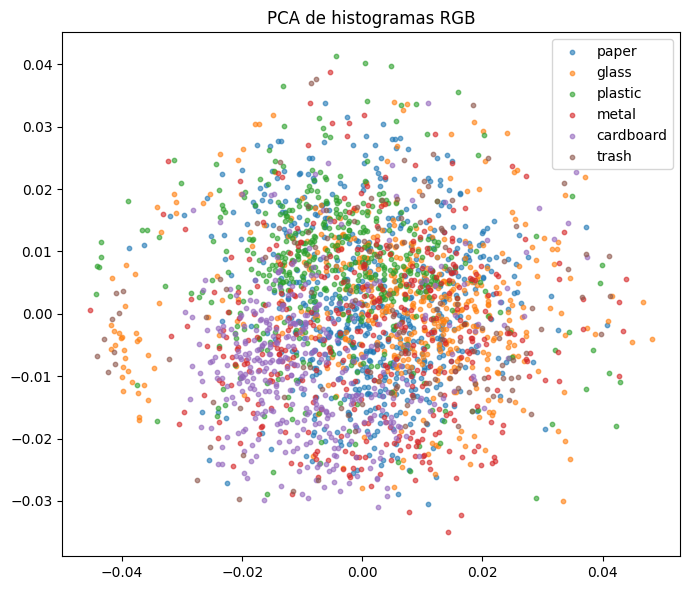

In [ ]:

H = meta_df[[f"hist_{i}" for i in range(48)]].fillna(0).values
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(H)
meta_df["pca_x"] = X2[:,0]; meta_df["pca_y"] = X2[:,1]
plt.figure(figsize=(7,6))
for cl in order:
    m = meta_df.label==cl
    plt.scatter(meta_df.loc[m,"pca_x"], meta_df.loc[m,"pca_y"], s=10, alpha=0.6, label=cl)
plt.legend()
plt.title("PCA de histogramas RGB")
plt.tight_layout()
plt.show()



## 14) Exportación de metadatos
Se guarda una tabla con todos los metadatos calculados para trazabilidad y posteriores análisis.


In [ ]:

meta_df.to_csv("trashnet_metadata.csv", index=False)
meta_df.shape


(2527, 64)